# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random as rn
import time

from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from platform import python_version_tuple
if python_version_tuple()[0] == '3':
    xrange = range
    izip = zip
    imap = map
else:
    from itertools import izip, imap

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


# Defining Variables

In [0]:
data_dir = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir(experiment)'

num_classes = 10
channels = 3
img_size = 224

resnet50_pooling = 'avg'
resnet50_weight = 'imagenet'
dense_layer_activation = 'softmax'
objective_function = 'categorical_crossentropy'
loss_metrics = ['accuracy']

learning_rate = 0.0001
beta_1=0.9
beta_2=0.999

num_epochs = 25
early_stop_patience = 3
steps_per_epochs_training = 10
steps_per_epochs_validation = 10
validation_split=0.25

batch_size_training = 50
batch_size_validation = 50
batch_size_testing = 1

# Preprocessing Dataset

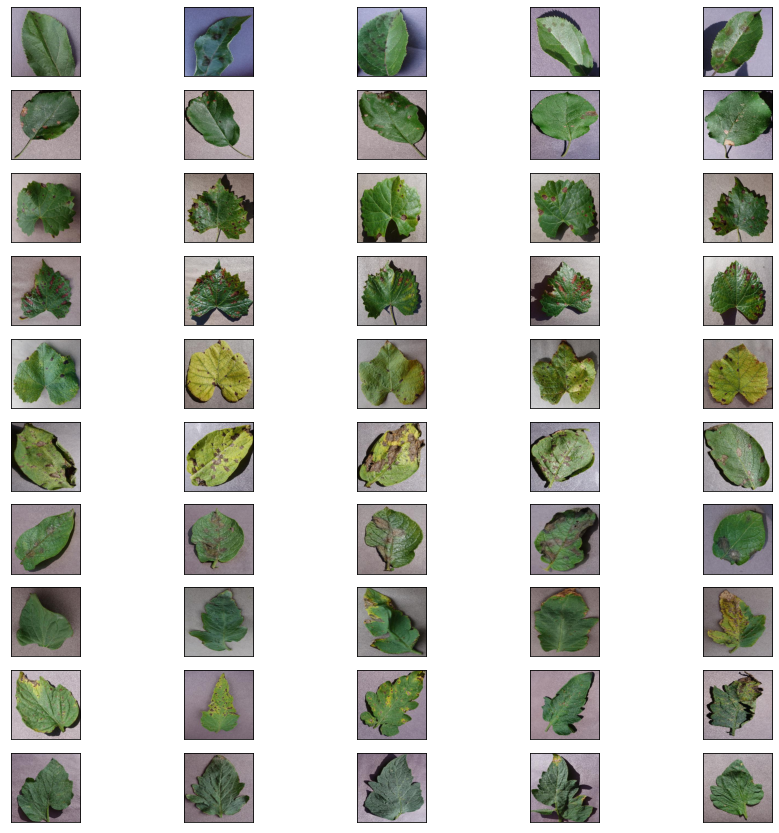

In [3]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
%matplotlib inline

files = [[path+f for f in os.listdir(path)[:5]] for path in [f'/content/drive/My Drive/Dataset/plantdisease-tugasakhir(experiment)/{x}/' for x in ['Apple___Apple_scab', 'Apple___Black_rot', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot']]]

fig, axs = plt.subplots(10, 5, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

for ax, img in zip(axs.flatten(), [item for sublist in files for item in sublist]):
    ax.imshow(load_img(img))

In [4]:
datagen = ImageDataGenerator(rescale=None,
                            rotation_range = 30,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split=validation_split, #test split
                            preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
                            data_dir,
                            target_size=(img_size, img_size),
                            batch_size=batch_size_training,
                            shuffle = True,
                            class_mode='categorical',
                            subset='training')

validation_generator = datagen.flow_from_directory(
                            data_dir,
                            target_size=(img_size, img_size),
                            batch_size=batch_size_validation,
                            shuffle = True,
                            class_mode='categorical',
                            subset='validation')

Found 380 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


In [0]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
%matplotlib inline

img_samples = 16

image_dir = '/content/preview/'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

img = load_img('/content/drive/My Drive/Dataset/plantdisease-tugasakhir(experiment)/Apple___Black_rot/f079c46a-6614-45ac-8ab6-187d126609e5___JR_FrgE.S 2767.JPG')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

from itertools import islice
list(islice(datagen.flow(x, batch_size=1, save_to_dir='/content/preview', save_prefix='cat', save_format='jpeg'), img_samples));

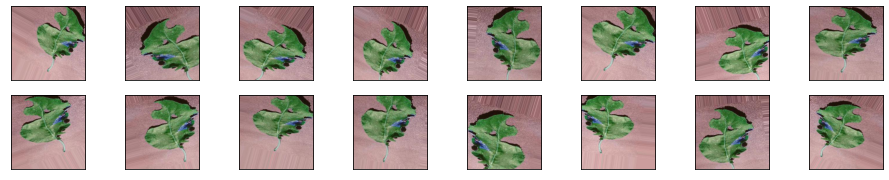

In [6]:
rows, cols = 2, img_samples // 2
fig, axs = plt.subplots(rows, cols, figsize=(16,3), subplot_kw={'xticks': [], 'yticks': []})

#for i, img in enumerate(os.listdir(image_dir)[:img_samples]):
#    axs[i//cols][i%cols].imshow(load_img(image_dir+img))

for ax, img in zip(axs.flatten(), os.listdir('/content/preview')[:img_samples]):
    ax.imshow(load_img('/content/preview/'+img))

In [0]:
start1 = time.process_time()
x1, y1 = izip(*(train_generator[i] for i in xrange(len(train_generator))))
x_train, y_train = np.vstack(x1), np.vstack(y1)

In [8]:
print(x_train.shape)
print(y_train.shape)

(380, 224, 224, 3)
(380, 10)


In [0]:
start2 = time.process_time()
x2, y2 = izip(*(validation_generator[i] for i in xrange(len(validation_generator))))
x_test, y_test = np.vstack(x2), np.vstack(y2)

In [10]:
print(x_test.shape)
print(y_test.shape)

(120, 224, 224, 3)
(120, 10)


# Defining the Model

In [11]:
resnet50 = ResNet50(include_top = False, pooling = resnet50_pooling, weights = resnet50_weight, input_shape=(img_size, img_size, channels))

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation = dense_layer_activation))
model.layers[0].trainable = False

In [0]:
adam = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
model.compile(optimizer = adam, loss = objective_function, metrics = loss_metrics)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

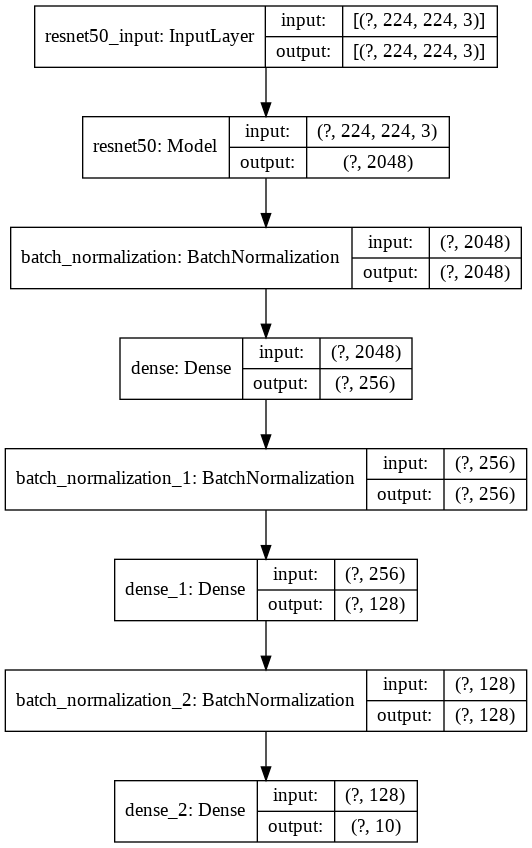

In [15]:
keras.utils.plot_model(model, "model_architecture.png", show_shapes=True)

# Training the Model

In [16]:
fit_history = model.fit(
        x_train,
        y_train,
        steps_per_epoch=steps_per_epochs_training,
        epochs = num_epochs,
        validation_data =(x_test, y_test))

Epoch 1/25
10/10 [==============================] - 4s 351ms/step - loss: 2.7709 - accuracy: 0.1474 - val_loss: 2.3150 - val_accuracy: 0.1167
Epoch 2/25
10/10 [==============================] - 1s 139ms/step - loss: 1.7714 - accuracy: 0.4026 - val_loss: 2.0966 - val_accuracy: 0.1917
Epoch 3/25
10/10 [==============================] - 1s 139ms/step - loss: 1.1022 - accuracy: 0.6789 - val_loss: 1.9123 - val_accuracy: 0.3583
Epoch 4/25
10/10 [==============================] - 1s 140ms/step - loss: 0.7240 - accuracy: 0.8000 - val_loss: 1.7597 - val_accuracy: 0.4583
Epoch 5/25
10/10 [==============================] - 1s 139ms/step - loss: 0.5413 - accuracy: 0.8921 - val_loss: 1.6412 - val_accuracy: 0.5333
Epoch 6/25
10/10 [==============================] - 1s 139ms/step - loss: 0.3728 - accuracy: 0.9632 - val_loss: 1.5444 - val_accuracy: 0.5917
Epoch 7/25
10/10 [==============================] - 1s 140ms/step - loss: 0.2795 - accuracy: 0.9842 - val_loss: 1.4648 - val_accuracy: 0.6083
Epoch 

In [17]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTrain accuracy:', train_acc)
print('Test accuracy:', test_acc)

12/12 - 2s - loss: 0.1397 - accuracy: 1.0000
4/4 - 0s - loss: 0.7819 - accuracy: 0.7667

Train accuracy: 1.0
Test accuracy: 0.7666666507720947


# Visualization

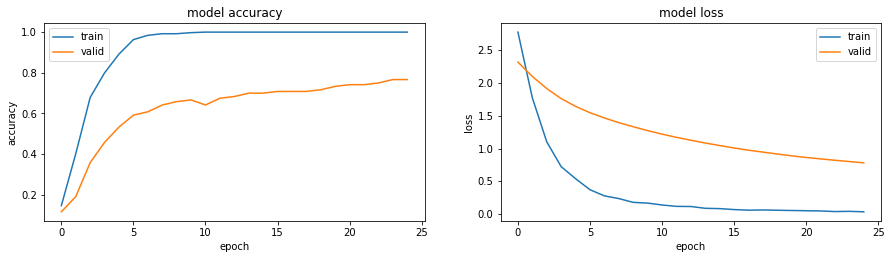

In [18]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

Report : 
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.83      0.83      0.83        12
           2       0.67      0.67      0.67        12
           3       0.77      0.83      0.80        12
           4       0.90      0.75      0.82        12
           5       0.83      0.83      0.83        12
           6       0.90      0.75      0.82        12
           7       0.80      0.67      0.73        12
           8       0.83      0.42      0.56        12
           9       0.60      1.00      0.75        12

    accuracy                           0.77       120
   macro avg       0.79      0.77      0.76       120
weighted avg       0.79      0.77      0.76       120



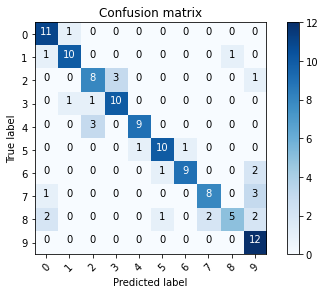

In [19]:
# Function to plot confusion matrix 
import itertools 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

#classification report
print('Report : ')
print(classification_report(Y_true, Y_pred_classes))

# Experimenting